In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
%matplotlib inline

In [2]:
def split_dataset(x, y, train_per, dev_per, test_per):
    """
        Splits dataset (i.e. x, y) into 3 parts, specified by their percentages
        Example: split_dataset(x, y, 80, 10, 10) will split x and y into the following:
        
        train: 80%
        dev: 10%
        test: 10%
        
        Note: x and y should be ndarray's of size: (M X N) where M is the no:of examples and N is some number
    """
    rows = x.shape[0]
    cols = x.shape[1]
    
    combined = np.hstack((x, y))
    np.random.shuffle(combined)
    
    x = combined[:,:cols]
    y = combined[:,cols:]
    
    train_size = int((train_per / 100) * rows)
    dev_size = int((dev_per / 100) * rows)
    test_size = int((test_per / 100) * rows)

    print("Total size: " + str(rows) + " Train size: " + str(train_size) +
          " Dev size: " + str(dev_size) + " Test size: " + str(test_size))
    
    train_x = x[:train_size]
    dev_x = x[train_size:train_size + dev_size]
    test_x = x[train_size + dev_size:]
    
    train_y = y[:train_size]
    dev_y = y[train_size:train_size + dev_size]
    test_y = y[train_size + dev_size:]
    
    return (train_x, dev_x, test_x, train_y, dev_y, test_y)

In [3]:
def de_normalize(mew, std, vec):
    """
        mew and std are numbers denoting the original mean and standard deviation of the vector.
        vec is of size (M X 1), i.e. it is a single feature vector
        
        Returns the denormalized vector
    """
    return ((vec * std) + mew) 

In [4]:
def normalize(vec):
    """
        vec is of size (M X 1), i.e. it is a single feature vector
        
        Returns a normalized vector
    """
    mew = np.average(vec)
    std = np.std(vec)
    return (mew, std, (vec - mew)/std)

In [5]:
def squared_error_cost(x, y, theta, lambd):
    """
        x is (M X (N + 1))
        y is (M X 1)
        theta is ((N + 1) X 1)
    """
    
    # calculate hypothesis
    h = x @ theta
    
    # calculate regularization term
    reg_term = np.sum(lambd * (theta[1:,:].reshape(theta.shape[0] - 1, 1) ** 2))
    
    # calculate cost and return it
    cost = (1/(2 * M)) * (np.sum((h - y) ** 2) + reg_term)
    return cost

In [6]:
def gradient_descent(alpha, lambd, x, y, theta, cost_func, num_iters, create_new_fig):
    """
        x is (M X (N + 1))
        y is (M X 1)
        theta is ((N + 1) X 1)
        
        create_new_fig : denotes whether to plot the graph on a new figure or not
        
        Runs gradient descent algorithm for num_iters times and returns the final theta and cost
        Also plots the way cost has varied over time
    """
    M = x.shape[0]
    cost_arr = []
    
    for i in range(num_iters):
        h = x @ theta
        reg_term = lambd * theta[1:]
        theta[0] = theta[0] - (alpha/M) * np.sum(h - y)
        theta[1:] = theta[1:] - (alpha/M) * (np.sum((h - y) * x[:,1:], axis=0, keepdims=True).T + reg_term)
        cost_arr.append(cost_func(x, y, theta, lambd))

    if(create_new_fig):
        fig = plt.figure(figsize=(12, 12), dpi= 80, facecolor='w', edgecolor='k')

    plt.plot(cost_arr)
    return theta

In [7]:
def predict(x_val, y_val, theta, mew_x, std_x, mew_y, std_y, col_names, print_samples, num_samples):
    """
        Performs predictions, given input x, y and theta. Also returns the RMSE accuracy of the predictions
        
        In order to calculate the RMSE accuracy, the mean and standard deviations (of x's and y's) are required.
        
        It also has the ability to print few sample prediction results (for comparision purposes)
    """

    h_val = x_val @ theta
    
    x = np.zeros(shape=x_val.shape)
    y = np.zeros(shape=y_val.shape)
    
    # Denormalize
    for i in range(1, x.shape[1]):
        x[:,i] = de_normalize(mew_x[i - 1], std_x[i - 1], x_val[:,i])
    
    y = de_normalize(mew_y, std_y, y_val)
    h = de_normalize(mew_y, std_y, h_val)
    
    # Calculate the accuracy
    rmse_accuracy = np.sqrt(((h - y) ** 2).mean())
    
    if(print_samples):
        # Take few samples for prediction
        sample_x, sample_y, sample_h = sample(x, y, h, num_samples)
        for i in range(sample_x.shape[0]):
            print("\n" + ("*" * 40))
            print("X value: ")
            for j in range(1, sample_x.shape[1]):
                print(str(sample_x[i][j]) + " " + col_names[j], end=" ")
            print("\nY value: " + str(sample_y[i][0]) + " " + col_names[0])
            print("Predicted value: " + str(sample_h[i][0]) + " " + col_names[0])
            print(("*" * 40) + "\n")

    
    return rmse_accuracy

In [8]:
def sample(a, b, c, num):
    """
        a and b and c are of size (M X N)
    
        Returns 'num' no:of samples randomly chosen from a and b
    """
    rand_index = np.arange(a.shape[0]).reshape(a.shape[0], 1)
    np.random.shuffle(rand_index)
    rand_index = rand_index[0:num]
    return a[rand_index].reshape(num, a.shape[1]), b[rand_index].reshape(num, b.shape[1]), c[rand_index].reshape(num, c.shape[1])

In [9]:
def check_imbalance(df, numeric_id, actual_column):
    print("\nCheck class imbalance for: " + actual_column)
    df = df[[numeric_id, actual_column]]
    df = df.groupby(actual_column)[numeric_id].nunique()
    print(df)
    print()

In [10]:
def pre_process_data(data):
    """
        Accepts a dataframe as input, performs pre-processing and returns (x, y, col_names)
        
        x (an ndarray) is the feature matrix of size (M X N) where M is the no:of examples and N is the no:of features
        y (an ndarray) contains actual results (of size (M X 1))
        col_names is a python list which contains the name of the columns present in y and x (of size ((N + 1) X 1))
        
        Note: The first element in col_names is the column name for y, the
        subsequent names are the names of features present in X
    """
    
    # Drop nan rows
    data = data.dropna()
    print("Shape of data after dropping NaN rows: " + str(data.shape))

    # check_imbalance(data, 'id', 'waterfront')

    # Retain only important data (feature engineering!)
    """
        From manual exploratory data analysis (EDA), a correlation has been observed
        between the columns: sqft_living, sqft_above, sqft_basement

        More specifically: sqft_living = sqft_above + sqft_basement

        Therefore it is better to retain only sqft_living column

        Moreover, we need not have 2 separate columns called "yr_renovated" and "yr_built"
        We can get away with max of those 2
    """
    data["house_birth"] = data[["yr_renovated", "yr_built"]].max(axis=1)

    col_names = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
                'floors', 'waterfront', 'condition', 'grade', 'house_birth',
                'lat', 'long']
    data = data[col_names]

    # Remove outliers
    data = data[data['bedrooms'] < 25]
    data = data[data['sqft_living'] < 13000]
    data = data[data['sqft_lot'] < 1500000]
    
    # Convert the data into numpy array
    data = data.values
    print(data.shape)

    # Extract input and output variables
    y = data[:,:1]
    x = data[:,1:]

#     # Visualize them
#     for i in range(x.shape[1]):
#         feature = x[:,i].reshape(x.shape[0], 1)
#         fig = plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
#         plt.plot(feature, y, 'bo', markersize=5, label=imp_cols[i + 1])
#         plt.legend(loc='upper left')
    
    return (x, y, col_names)

In [11]:
def pre_process_data_new(data):
    """
        Accepts a dataframe as input, performs pre-processing and returns (x, y, col_names)
        
        x (an ndarray) is the feature matrix of size (M X N) where M is the no:of examples and N is the no:of features
        y (an ndarray) contains actual results (of size (M X 1))
        col_names is a python list which contains the name of the columns present in y and x (of size ((N + 1) X 1))
        
        Note: The first element in col_names is the column name for y, the
        subsequent names are the names of features present in X
    """
    # Reorder the columns
    cols = data.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    data = data[cols]
    
    # Drop nan rows
    data = data.dropna()
    print("Shape of data after dropping NaN rows: " + str(data.shape))
    print(data.head())

    # check_imbalance(data, 'id', 'waterfront')

#     # Retain only important data (feature engineering!)
#     data["house_birth"] = data[["yr_renovated", "yr_built"]].max(axis=1)

    col_names = ['sound_pressure', 'hertz', 'angle', 'chord_length', 'velocity', 'thickness']
    data = data[col_names]

#     # Remove outliers
#     data = data[data['bedrooms'] < 25]
#     data = data[data['sqft_living'] < 13000]
#     data = data[data['sqft_lot'] < 1500000]
    
    # Convert the data into numpy array
    data = data.values
    print(data.shape)

    # Extract input and output variables
    y = data[:,:1]
    x = data[:,1:]

    # Visualize them
    for i in range(x.shape[1]):
        feature = x[:,i].reshape(x.shape[0], 1)
        fig = plt.figure(figsize=(9, 8), dpi= 80, facecolor='w', edgecolor='k')
        plt.plot(feature, y, 'bo', markersize=5, label=col_names[i + 1])
        plt.legend(loc='upper left')
    
    return (x, y, col_names)

In [12]:
def gradient_descent_optimize(train_x, dev_x, train_y, dev_y, cross_validation_times,
                              cost_func, alpha, num_iters, lambd):
    """
        Performs training on train_x and train_y using the cost_func() cost function
        
        Starts by randomly initializing the theta vector. Multiple random initializations
        are done, 'cross_validation_times' times, and a global optimal theta is returned
        
        Each random initialization result is tested on dev_x and dev_y
    """

    global_min_cost = sys.maxsize
    global_optimal_theta = np.empty((N + 1, 1))

    # Loop which runs multiple times (Each time trying a new random initialization)
    for i in range(cross_validation_times):
        theta = np.random.rand(N + 1, 1)
        optimal_theta = gradient_descent(alpha, lambd, train_x, train_y, theta, cost_func, num_iters, i==0)
        min_cost = cost_func(dev_x, dev_y, optimal_theta, lambd)
        if(min_cost < global_min_cost):
            global_min_cost = min_cost
            global_optimal_theta = optimal_theta
            
    return global_optimal_theta

In [13]:
def normal_equation_method(x, y):
    return np.linalg.inv(np.transpose(x) @ x) @ np.transpose(x) @ y

Shape of data read: (1503, 6)
Shape of data after dropping NaN rows: (1503, 6)
   sound_pressure  hertz  angle  chord_length  velocity  thickness
0         126.201    800    0.0        0.3048      71.3   0.002663
1         125.201   1000    0.0        0.3048      71.3   0.002663
2         125.951   1250    0.0        0.3048      71.3   0.002663
3         127.591   1600    0.0        0.3048      71.3   0.002663
4         127.461   2000    0.0        0.3048      71.3   0.002663
(1503, 6)
Total size: 1503 Train size: 1052 Dev size: 300 Test size: 150
Optimal value of theta: 
[[ 0.01110737]
 [-0.54764116]
 [-0.2383416 ]
 [-0.43117207]
 [ 0.21602534]
 [-0.36081565]]
Cost on dev set: 0.04462784847781747

****************************************
X value: 
1000.0 hertz 19.7 angle 0.0508 chord_length 39.6 velocity 0.036483999999999996 thickness 
Y value: 118.904 sound_pressure
Predicted value: 120.43603651391436 sound_pressure
****************************************


*************************

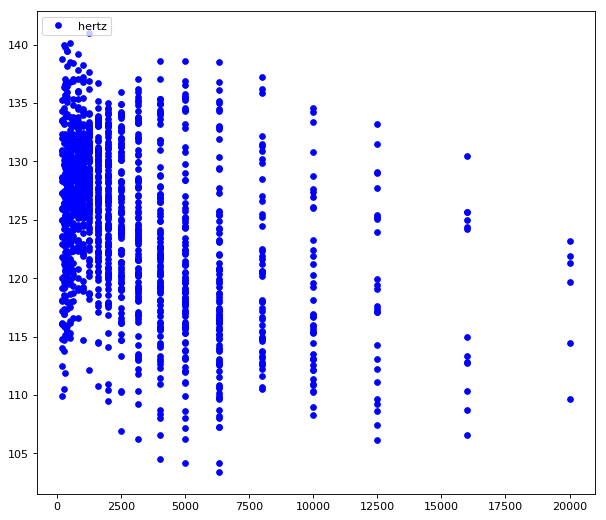

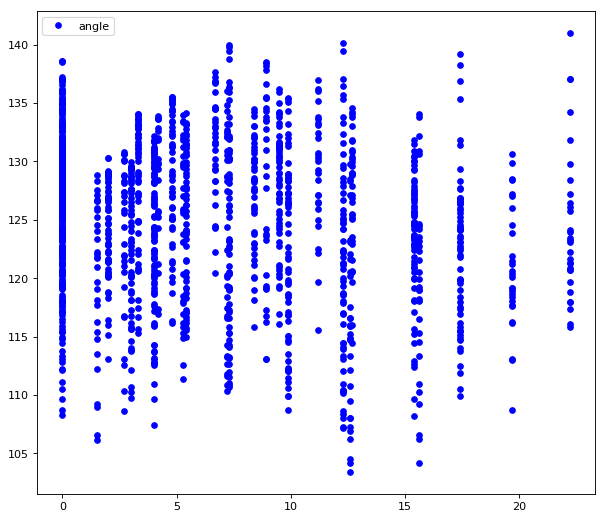

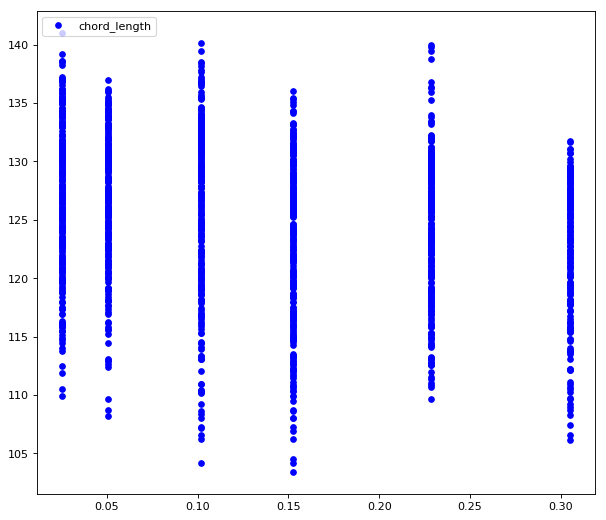

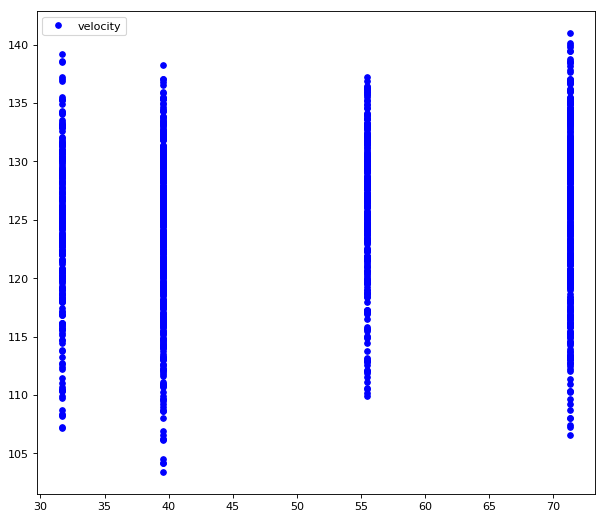

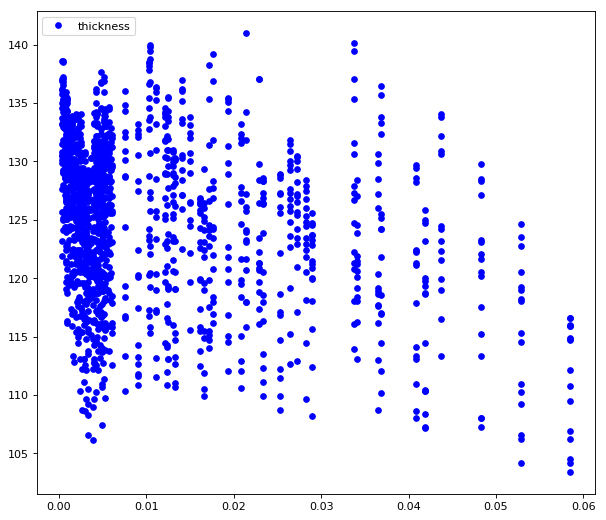

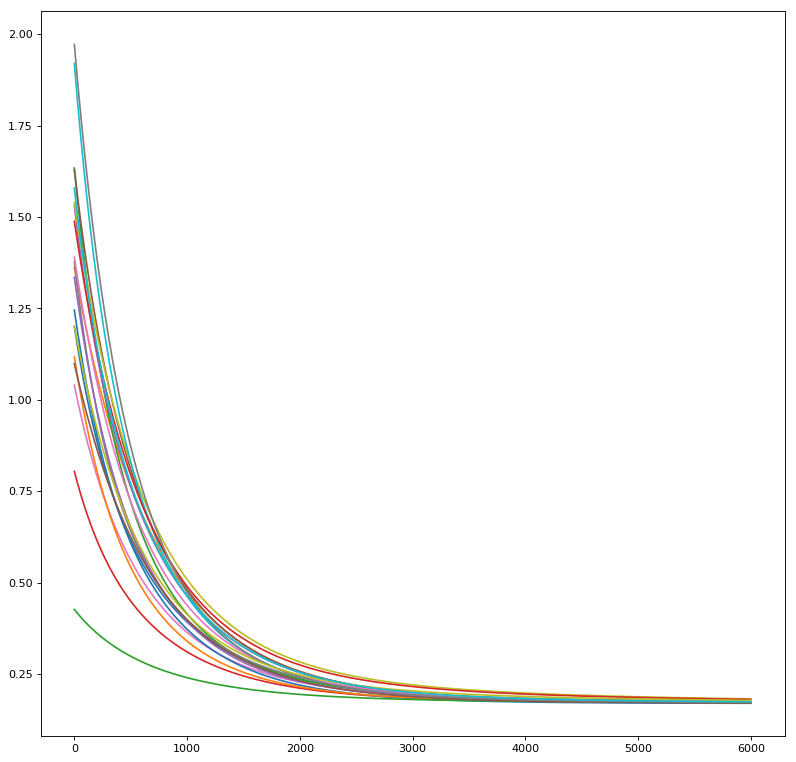

In [14]:
# # Read data from text file
# house_data = pd.read_csv('./kc_house_data.csv')
# print("Shape of data read: " + str(house_data.shape))

# # Preprocess the data
# (x, y, col_names) = pre_process_data(house_data)

# Read data from text file
air_foil_data = pd.read_csv('./uci_airfoil_self_noise_dataset.csv')
print("Shape of data read: " + str(air_foil_data.shape))

# Preprocess the data
(x, y, col_names) = pre_process_data_new(air_foil_data)


M = x.shape[0]
N = x.shape[1]

# Normalize features
mew_x = []
std_x = []
for i in range(N):
    (mew_val, std_val, x[:,i]) = normalize(x[:,i])
    mew_x.append(mew_val)
    std_x.append(std_val)
(mew_y, std_y, y) = normalize(y)

# Add x0 to x
ones_vec = np.ones((M, 1), dtype=int)
x = np.hstack((ones_vec, x))

# Split the dataset
(train_x, dev_x, test_x, train_y, dev_y, test_y) = split_dataset(x, y, 70, 20, 10)

# Set the regularization parameter
lambd = 0

# Optimize
optimal_theta = gradient_descent_optimize(train_x, dev_x, train_y, dev_y, 20, squared_error_cost, 0.001, 6000, lambd)

# Results
print("Optimal value of theta: \n" + str(optimal_theta))

print("Cost on dev set: " + str(squared_error_cost(dev_x, dev_y, optimal_theta, lambd)))
rmse = predict(dev_x, dev_y, optimal_theta, mew_x, std_x, mew_y, std_y, col_names, True, 3)
print("RMSE accuracy on dev set: " + str(rmse))

print("\n\nCost on test set: " + str(squared_error_cost(test_x, test_y, optimal_theta, lambd)))
rmse = predict(test_x, test_y, optimal_theta, mew_x, std_x, mew_y, std_y, col_names, True, 3)
print("RMSE accuracy on test set: " + str(rmse))